# Introduzione

Il seguente studio ha lo scopo di studiare se e in che modo la pirateria informatica può influenzare i servizi di streaming; a tale scopo, si è scelto di confrontare i dati finanziari di Spotify, piattaforma di streaming di musica e altri contenuti audio, con i downlaod dell'apk.

## Domande di ricerca 
1) Da dove arrivano i guadagni (ad vs premium)
2) Quanto l'apk di Spotify influenza i guadagni e il numero di utenti paganti 
3) Spotify è in perdita? 

## Librerie utilizzate 

* Numpy e pandas per la gestione dei dataset 
* Matplotlib per la visualizzazione dei dati 
* scipy.stats per le funzioni statistiche 
* ruptures per le analisi dei changepoint 
* statsmodels per la granger causality 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
import ruptures as rpt 
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
data_path = './data/'

quarterly_df = pd.read_csv(f'{data_path}spoty.csv')
apk_df = pd.read_csv(f'{data_path}apk.csv', parse_dates=['Date'])

# Dataset

## Dati finanziari Spotify
È stato utilizzato un dataset creato a partire dai dati pubblicati da Spotify sul sito (// TODO link sito), integrandoli con dati non pubblicati liberamente dall'azienda, ma presenti su un dataset di Kaggle (// TODO link kaggle).

## Download dell'apk
Per studiare il numero di download dell'apk si è fatto riferimento ai dati pubblicati da uno dei principali siti di download di software per Android (// TODO inserire link sito).

## Manipolazioni sui dataframe
Per semplificare la visualizzazione dei dati, si inserisce nel dataframe relativo a Spotify una colonna aggiuntiva (denominata `Date`) per indicare insieme anno e trimestre (*quarter*).

In [3]:
quarterly_df['Date'] = quarterly_df['Year'].astype(str) + ' – Q' + quarterly_df['Quarter'].astype(str)
quarterly_df = quarterly_df.sort_values('Date')

## Aggregazioni per trimestre dei download dell'apk
Per confrontare i dati finanziari con i dati dell'apk, è necessario aggregare questi ultimi per trimestre (i dati sono forniti a intervalli variabili).

In [4]:
apk_df.set_index('Date', inplace=True)
apk_quarterly_df = apk_df['Downloads'].resample('QE').sum().to_frame()
apk_df.reset_index(inplace=True)
apk_quarterly_df.reset_index(inplace=True)

apk_quarterly_df['Year'] = apk_quarterly_df['Date'].dt.year 
apk_quarterly_df['Quarter'] = apk_quarterly_df['Date'].dt.quarter 
apk_quarterly_df['Date'] = apk_quarterly_df['Year'].astype(str) + ' – Q' + apk_quarterly_df['Quarter'].astype(str)

## Calcolo MAUs marginali
I download dell'apk possono essere visti, al netto di download multipli da parte di uno stesso utente, come indicativi dell'incremento degli utenti che ne usufruiscono nel corso del tempo, piuttosto che indicativi del numero totale di fruitori. Per questo motivo, può avere più senso confrontare questo valore con l'incremento dei MAUs in ogni trimestre, invece che con i MAUs stessi.

Si calcolano di seguito i MAUs (MAUs, Premium MAUs, Ad MAUs) marginali.

In [5]:
quarterly_df['Marginal MAUs'] = quarterly_df['MAUs'].diff()
quarterly_df['Marginal Premium MAUs'] = quarterly_df['Premium MAUs'].diff()
quarterly_df['Marginal Ad MAUs'] = quarterly_df['Ad MAUs'].diff()

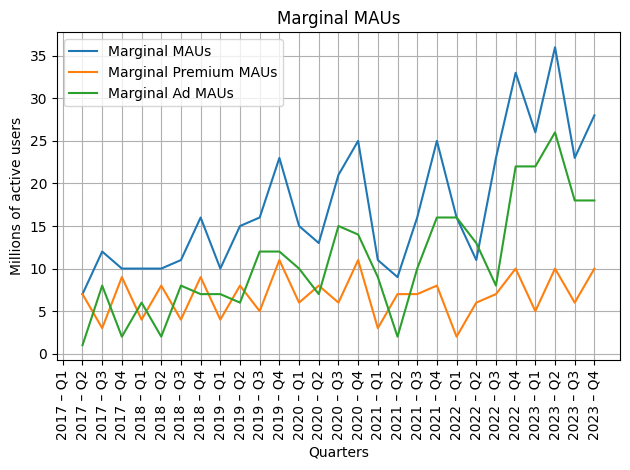

In [6]:
plt.figure()
plt.plot(quarterly_df['Date'], quarterly_df['Marginal MAUs'], label='Marginal MAUs')
plt.plot(quarterly_df['Date'], quarterly_df['Marginal Premium MAUs'], label='Marginal Premium MAUs')
plt.plot(quarterly_df['Date'], quarterly_df['Marginal Ad MAUs'], label='Marginal Ad MAUs')
plt.xticks(rotation=90)
plt.title('Marginal MAUs')
plt.xlabel('Quarters')
plt.ylabel('Millions of active users')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

## Visualizzazione di alcuni dati non processati
Si riportano qui di seguito alcune visualizzazioni dei dati presenti nel dataset, al fine di offrire una panoramica su alcuni aspetti rilevanti per la successiva analisi.

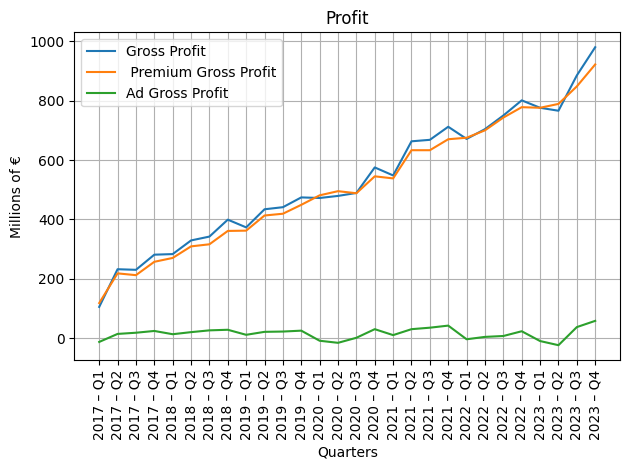

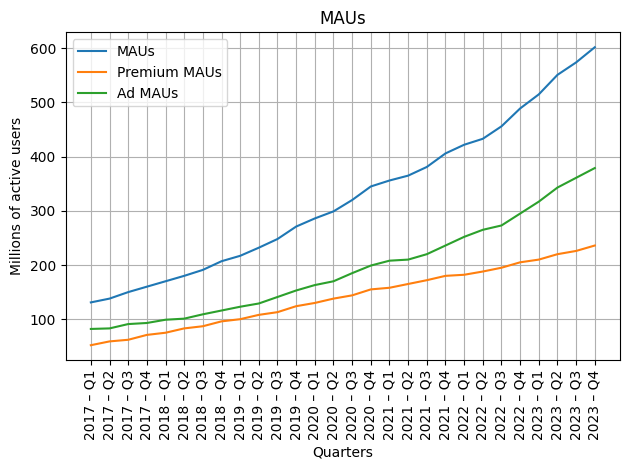

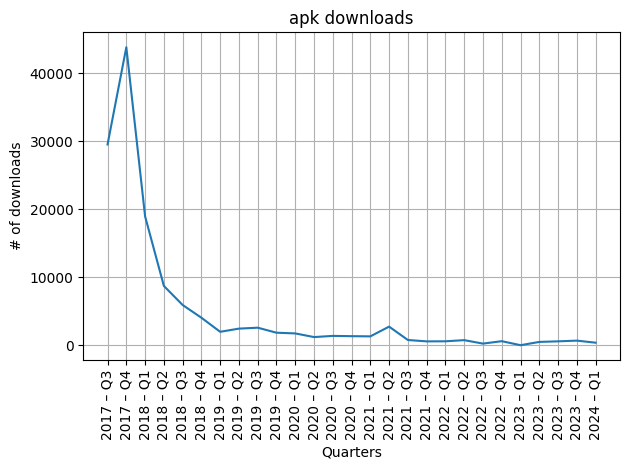

In [7]:
plt.figure()
plt.plot(quarterly_df['Date'], quarterly_df['Gross Profit'], label='Gross Profit')
plt.plot(quarterly_df['Date'], quarterly_df['Premium Gross Profit'], label=' Premium Gross Profit')
plt.plot(quarterly_df['Date'], quarterly_df['Ad Gross Profit'], label='Ad Gross Profit')
plt.xticks(rotation=90)
plt.title('Profit')
plt.xlabel('Quarters')
plt.ylabel('Millions of €')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure()
plt.plot(quarterly_df['Date'], quarterly_df['MAUs'], label='MAUs')
plt.plot(quarterly_df['Date'], quarterly_df['Premium MAUs'], label='Premium MAUs')
plt.plot(quarterly_df['Date'], quarterly_df['Ad MAUs'], label='Ad MAUs')
plt.xticks(rotation=90)
plt.title('MAUs')
plt.xlabel('Quarters')
plt.ylabel('Millions of active users')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure()
plt.plot(apk_quarterly_df['Date'], apk_quarterly_df['Downloads'])

plt.xticks(rotation=90)
plt.title('apk downloads')
plt.xlabel('Quarters')
plt.ylabel('# of downloads')
plt.tight_layout()
plt.grid()
plt.show()


# Metodo proposto

# Risultati sperimentali

## Fonti di guadagno di Spotify

### Percentuale dei guadagni sui ricavi

In [8]:
quarterly_df['Profit Percentage'] = quarterly_df['Gross Profit'] / quarterly_df['Total Revenue'] * 100
quarterly_df['Premium Profit Percentage'] = quarterly_df['Premium Gross Profit'] / quarterly_df['Total Revenue'] * 100
quarterly_df['Ad Profit Percentage'] = quarterly_df['Ad Gross Profit'] / quarterly_df['Total Revenue'] * 100

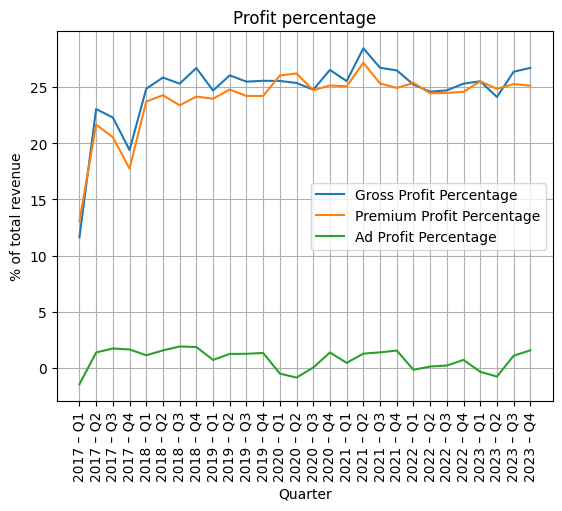

In [9]:
plt.figure()
plt.plot(quarterly_df['Date'], quarterly_df['Profit Percentage'], label='Gross Profit Percentage')
plt.plot(quarterly_df['Date'], quarterly_df['Premium Profit Percentage'], label='Premium Profit Percentage')
plt.plot(quarterly_df['Date'], quarterly_df['Ad Profit Percentage'], label='Ad Profit Percentage')

plt.title('Profit percentage')
plt.xlabel('Quarter')
plt.ylabel('% of total revenue')
plt.xticks(rotation=90)
plt.grid()
plt.legend()
plt.show()

### Correlazione tra guadagni e MAUs

In [10]:
pearson_corr_profit_maus, pearson_profit_maus_pvalue = pearsonr(quarterly_df['Premium MAUs'], quarterly_df['Gross Profit'])
print(f'Pearson correlation: {pearson_corr_profit_maus}')
print(f'p-value: {pearson_profit_maus_pvalue}')
print('\n')

spearman_corr_profit_maus, spearman_profit_maus_pvalue = spearmanr(quarterly_df['Premium MAUs'], quarterly_df['Gross Profit'])
print(f'Spearman correlation: {spearman_corr_profit_maus}')
print(f'p-value: {spearman_profit_maus_pvalue}')
print('\n')

kendalltau_corr_profit_maus, kendalltau_profit_maus_pvalue = kendalltau(quarterly_df['Premium MAUs'], quarterly_df['Gross Profit'])
print(f'Kendall Tau correlation: {kendalltau_corr_profit_maus}')
print(f'p-value: {kendalltau_profit_maus_pvalue}')

Pearson correlation: 0.9865791719644258
p-value: 5.397965670764151e-22


Spearman correlation: 0.9939792008757526
p-value: 1.6771999002826718e-26


Kendall Tau correlation: 0.9523809523809524
p-value: 5.736864432215488e-22


In [11]:
pearson_corr_profit_maus, pearson_profit_maus_pvalue = pearsonr(quarterly_df['Ad MAUs'], quarterly_df['Gross Profit'])
print(f'Pearson correlation: {pearson_corr_profit_maus}')
print(f'p-value: {pearson_profit_maus_pvalue}')
print('\n')

spearman_corr_profit_maus, spearman_profit_maus_pvalue = spearmanr(quarterly_df['Ad MAUs'], quarterly_df['Gross Profit'])
print(f'Spearman correlation: {spearman_corr_profit_maus}')
print(f'p-value: {spearman_profit_maus_pvalue}')
print('\n')

kendalltau_corr_profit_maus, kendalltau_profit_maus_pvalue = kendalltau(quarterly_df['Ad MAUs'], quarterly_df['Gross Profit'])
print(f'Kendall Tau correlation: {kendalltau_corr_profit_maus}')
print(f'p-value: {kendalltau_profit_maus_pvalue}')

Pearson correlation: 0.9678454927709811
p-value: 4.1634908732952465e-17


Spearman correlation: 0.9939792008757526
p-value: 1.6771999002826718e-26


Kendall Tau correlation: 0.9523809523809524
p-value: 5.736864432215488e-22


### Calcolo dei changepoint

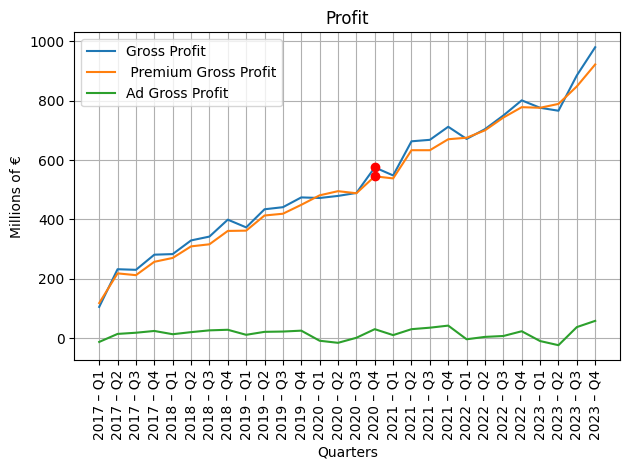

In [12]:
profit_labels = ['Gross Profit', 'Premium Gross Profit', 'Ad Gross Profit']

changepoints = dict()
for feature in profit_labels:
    algo = rpt.Pelt(model='rbf').fit(quarterly_df[feature].values)
    result = algo.predict(pen=6) 
    changepoints[feature] = filter(lambda x: x < quarterly_df[feature].count(), result)

plt.figure()
plt.plot(quarterly_df['Date'], quarterly_df['Gross Profit'], label='Gross Profit')
plt.plot(quarterly_df['Date'], quarterly_df['Premium Gross Profit'], label=' Premium Gross Profit')
plt.plot(quarterly_df['Date'], quarterly_df['Ad Gross Profit'], label='Ad Gross Profit')


for label in profit_labels:
    for point in changepoints[label]:
        plt.plot(point, quarterly_df[label].loc[point], 'ro')


plt.xticks(rotation=90)
plt.title('Profit')
plt.xlabel('Quarters')
plt.ylabel('Millions of €')
plt.legend()
plt.tight_layout()
plt.grid()

plt.show()


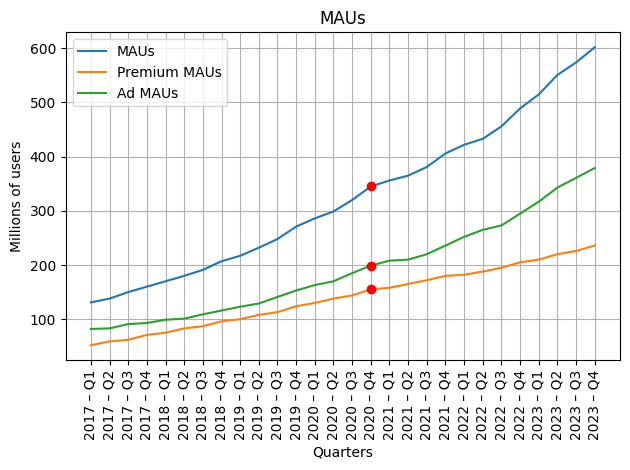

In [13]:
maus_labels = ['MAUs', 'Premium MAUs', 'Ad MAUs']

changepoints = dict()
for feature in maus_labels:
    algo = rpt.Pelt(model='rbf').fit(quarterly_df[feature].values)
    result = algo.predict(pen=6) 
    changepoints[feature] = filter(lambda x: x < quarterly_df[feature].count(), result)

plt.figure()

for label in maus_labels:
    plt.plot(quarterly_df['Date'], quarterly_df[label], label=label)


for label in maus_labels:
    for point in changepoints[label]:
        plt.plot(point, quarterly_df[label].loc[point], 'ro')
        


plt.xticks(rotation=90)
plt.title('MAUs')
plt.xlabel('Quarters')
plt.ylabel('Millions of users')
plt.legend()
plt.tight_layout()
plt.grid()

plt.show()

### Granger causality di premium/ad MAUS su gross profit

In [14]:
granger_premium_maus = grangercausalitytests(quarterly_df[['Gross Profit', 'Premium MAUs']], maxlag=1)
print(granger_premium_maus)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.4191 , p=0.0006  , df_denom=24, df_num=1
ssr based chi2 test:   chi2=17.3464 , p=0.0000  , df=1
likelihood ratio test: chi2=13.3973 , p=0.0003  , df=1
parameter F test:         F=15.4191 , p=0.0006  , df_denom=24, df_num=1
{1: ({'ssr_ftest': (15.419059399836522, 0.0006339831017818883, 24.0, 1), 'ssr_chi2test': (17.346441824816086, 3.1148089875903534e-05, 1), 'lrtest': (13.397281472795328, 0.0002519892500313163, 1), 'params_ftest': (15.419059399836515, 0.0006339831017818898, 24.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1070dc340>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x169293e20>, array([[0., 1., 0.]])])}


In [15]:
granger_ad_maus = grangercausalitytests(quarterly_df[['Gross Profit', 'Ad MAUs']], maxlag=1)
print(granger_ad_maus)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.1532 , p=0.0002  , df_denom=24, df_num=1
ssr based chi2 test:   chi2=21.5474 , p=0.0000  , df=1
likelihood ratio test: chi2=15.8410 , p=0.0001  , df=1
parameter F test:         F=19.1532 , p=0.0002  , df_denom=24, df_num=1
{1: ({'ssr_ftest': (19.153235919794586, 0.0002028042869717894, 24.0, 1), 'ssr_chi2test': (21.54739040976891, 3.451920740421288e-06, 1), 'lrtest': (15.840996571364542, 6.889354515106239e-05, 1), 'params_ftest': (19.153235919794604, 0.00020280428697178838, 24.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1692c32b0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1692b8d60>, array([[0., 1., 0.]])])}


## Quanto l'apk influenza i guadagni di Spotify

È innanzitutto necessario troncare le due serie, per poterle confrontare nello stesso intervallo temporale (2017Q3 – 2023Q4).

In [29]:
start_date = max(quarterly_df['Date'].min(), apk_quarterly_df['Date'].min())
end_date = min(quarterly_df['Date'].max(), apk_quarterly_df['Date'].max())

trunc_quarterly_df = quarterly_df[
    (quarterly_df['Date'] >= start_date) &
    (quarterly_df['Date'] <= end_date)
].reset_index()

trunc_apk_quarterly_df = apk_quarterly_df[
    (apk_quarterly_df['Date'] >= start_date) &
    (apk_quarterly_df['Date'] <= end_date)
].reset_index()

### Correlazione tra Premium MAUs e download apk

In [17]:
pearson_corr_maus, pearson_pvalue = pearsonr(trunc_quarterly_df['MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Pearson correlation: {pearson_corr_maus}')
print(f'p-value: {pearson_pvalue}')
print('\n')

spearman_corr_maus, spearman_pvalue = spearmanr(trunc_quarterly_df['MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Spearman correlation: {spearman_corr_maus}')
print(f'p-value: {spearman_pvalue}')
print('\n')

kendalltau_corr_maus, kendalltau_pvalue = kendalltau(trunc_quarterly_df['MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Kendall Tau correlation: {kendalltau_corr_maus}')
print(f'p-value: {kendalltau_pvalue}')

Pearson correlation: -0.5643699439816536
p-value: 0.0026705638963746858


Spearman correlation: -0.9206837606837606
p-value: 2.7168222882982103e-11


Kendall Tau correlation: -0.7846153846153847
p-value: 1.030182378596434e-10


In [18]:
pearson_corr_maus, pearson_pvalue = pearsonr(trunc_quarterly_df['Premium MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Pearson correlation: {pearson_corr_maus}')
print(f'p-value: {pearson_pvalue}')
print('\n')

spearman_corr_maus, spearman_pvalue = spearmanr(trunc_quarterly_df['Premium MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Spearman correlation: {spearman_corr_maus}')
print(f'p-value: {spearman_pvalue}')
print('\n')

kendalltau_corr_maus, kendalltau_pvalue = kendalltau(trunc_quarterly_df['Premium MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Kendall Tau correlation: {kendalltau_corr_maus}')
print(f'p-value: {kendalltau_pvalue}')

Pearson correlation: -0.6223810216218667
p-value: 0.0006859359176054387


Spearman correlation: -0.9206837606837606
p-value: 2.7168222882982103e-11


Kendall Tau correlation: -0.7846153846153847
p-value: 1.030182378596434e-10


In [19]:
pearson_corr_maus, pearson_pvalue = pearsonr(trunc_quarterly_df['Ad MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Pearson correlation: {pearson_corr_maus}')
print(f'p-value: {pearson_pvalue}')
print('\n')

spearman_corr_maus, spearman_pvalue = spearmanr(trunc_quarterly_df['Ad MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Spearman correlation: {spearman_corr_maus}')
print(f'p-value: {spearman_pvalue}')
print('\n')

kendalltau_corr_maus, kendalltau_pvalue = kendalltau(trunc_quarterly_df['Ad MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Kendall Tau correlation: {kendalltau_corr_maus}')
print(f'p-value: {kendalltau_pvalue}')

Pearson correlation: -0.5290620953767572
p-value: 0.005452090172946295


Spearman correlation: -0.9206837606837606
p-value: 2.7168222882982103e-11


Kendall Tau correlation: -0.7846153846153847
p-value: 1.030182378596434e-10


### Correlazione tra guadagni e download apk

In [20]:
pearson_corr_profit, pearson_pvalue = pearsonr(trunc_quarterly_df['Gross Profit'], trunc_apk_quarterly_df['Downloads'])
print(f'Pearson correlation: {pearson_corr_profit}')
print(f'p-value: {pearson_pvalue}')
print('\n')

spearman_corr_profit, spearman_pvalue = spearmanr(trunc_quarterly_df['Gross Profit'], trunc_apk_quarterly_df['Downloads'])
print(f'Spearman correlation: {spearman_corr_profit}')
print(f'p-value: {spearman_pvalue}')
print('\n')

kendalltau_corr_profit, kendalltau_pvalue = kendalltau(trunc_quarterly_df['Gross Profit'], trunc_apk_quarterly_df['Downloads'])
print(f'Kendall Tau correlation: {kendalltau_corr_profit}')
print(f'p-value: {kendalltau_pvalue}')

Pearson correlation: -0.5996170073666743
p-value: 0.001205762527065065


Spearman correlation: -0.9158974358974358
p-value: 5.351641398854512e-11


Kendall Tau correlation: -0.7723076923076924
p-value: 2.684186268483488e-10


In [21]:
pearson_corr_profit, pearson_pvalue = pearsonr(trunc_quarterly_df['Premium Gross Profit'], trunc_apk_quarterly_df['Downloads'])
print(f'Pearson correlation: {pearson_corr_profit}')
print(f'p-value: {pearson_pvalue}')
print('\n')

spearman_corr_profit, spearman_pvalue = spearmanr(trunc_quarterly_df['Premium Gross Profit'], trunc_apk_quarterly_df['Downloads'])
print(f'Spearman correlation: {spearman_corr_profit}')
print(f'p-value: {spearman_pvalue}')
print('\n')

kendalltau_corr_profit, kendalltau_pvalue = kendalltau(trunc_quarterly_df['Premium Gross Profit'], trunc_apk_quarterly_df['Downloads'])
print(f'Kendall Tau correlation: {kendalltau_corr_profit}')
print(f'p-value: {kendalltau_pvalue}')

Pearson correlation: -0.6125000086572273
p-value: 0.0008808465453877038


Spearman correlation: -0.9146862845258472
p-value: 6.312923208140776e-11


Kendall Tau correlation: -0.7765802747153208
p-value: 2.763106384473543e-08


In [22]:
pearson_corr_maus, pearson_pvalue = pearsonr(trunc_quarterly_df['Ad MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Pearson correlation: {pearson_corr_maus}')
print(f'p-value: {pearson_pvalue}')
print('\n')

spearman_corr_maus, spearman_pvalue = spearmanr(trunc_quarterly_df['Ad MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Spearman correlation: {spearman_corr_maus}')
print(f'p-value: {spearman_pvalue}')
print('\n')

kendalltau_corr_maus, kendalltau_pvalue = kendalltau(trunc_quarterly_df['Ad MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Kendall Tau correlation: {kendalltau_corr_maus}')
print(f'p-value: {kendalltau_pvalue}')

Pearson correlation: -0.5290620953767572
p-value: 0.005452090172946295


Spearman correlation: -0.9206837606837606
p-value: 2.7168222882982103e-11


Kendall Tau correlation: -0.7846153846153847
p-value: 1.030182378596434e-10


### Correlazione tra Premium MAUs marginali

In [23]:
pearson_corr_marginal_maus, pearson_marginal_pvalue = pearsonr(trunc_quarterly_df['Marginal Premium MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Pearson correlation: {pearson_corr_marginal_maus}')
print(f'p-value: {pearson_marginal_pvalue}')
print('\n')

spearman_corr_marginal_maus, spearman_marginal_pvalue = spearmanr(trunc_quarterly_df['Marginal Premium MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Spearman correlation: {spearman_corr_marginal_maus}')
print(f'p-value: {spearman_marginal_pvalue}')
print('\n')

kendalltau_corr_marginal_maus, kendalltau_marginal_pvalue = kendalltau(trunc_quarterly_df['Marginal Premium MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Kendall Tau correlation: {kendalltau_corr_marginal_maus}')
print(f'p-value: {kendalltau_marginal_pvalue}')

Pearson correlation: -0.09670169273907739
p-value: 0.6383997581432619


Spearman correlation: -0.1228093718374692
p-value: 0.5500538723379269


Kendall Tau correlation: -0.08326663997864531
p-value: 0.5635104573765848


### Granger causality di download apk su Premium MAUs marginali

In [32]:
apk_maus_marginal = pd.DataFrame()
apk_maus_marginal['Downloads'] = trunc_apk_quarterly_df['Downloads']
apk_maus_marginal['Marginal Premium MAUs'] = trunc_quarterly_df['Marginal Premium MAUs']
granger_apk_maus_marginal = grangercausalitytests(apk_maus_marginal[['Downloads', 'Marginal Premium MAUs']], maxlag=1)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7361  , p=0.1123  , df_denom=22, df_num=1
ssr based chi2 test:   chi2=3.1092  , p=0.0779  , df=1
likelihood ratio test: chi2=2.9305  , p=0.0869  , df=1
parameter F test:         F=2.7361  , p=0.1123  , df_denom=22, df_num=1


### Granger causality di download apk su gross profit

In [31]:
apk_maus_marginal = pd.DataFrame()
apk_maus_marginal['Downloads'] = trunc_apk_quarterly_df['Downloads']
apk_maus_marginal['Gross Profit'] = trunc_quarterly_df['Gross Profit']
granger_apk_maus_marginal = grangercausalitytests(apk_maus_marginal[['Downloads', 'Gross Profit']], maxlag=1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4699  , p=0.5002  , df_denom=22, df_num=1
ssr based chi2 test:   chi2=0.5340  , p=0.4649  , df=1
likelihood ratio test: chi2=0.5284  , p=0.4673  , df=1
parameter F test:         F=0.4699  , p=0.5002  , df_denom=22, df_num=1
